In [19]:
# Import libraries
import os
import sys
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import re
from skimage import io
import tifffile
from scipy.ndimage import median_filter
from skimage.util import img_as_ubyte,  img_as_float
import skimage
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt
import scipy
import seaborn as sns
from scipy import stats

# Set Paths
codedir = os.getcwd()

%matplotlib inline

In [2]:
#images: dowload from synapse.org syn51068458
# (free account required)
rootdir = '/home/groups/BCC_Chin_Lab/ChinData/Cyclic_Workflow/cmIF_2021-05-03_PDAC'
regdir = f'{rootdir}/RegisteredImages'
segdir = f'{codedir}/Segmentation'
segdiro = f'{rootdir}/Segmentation'

# clone mplex_image at https://gitlab.com/engje/mplex_image
os.chdir('/home/groups/graylab_share/data/engje/Data/')
from mplex_image import preprocess, mpimage, cmif
os.chdir(codedir)

# Table of contents <a name="contents"></a>
1. [functions](#func)
3. [skimage blobs](#sk)
3. [Foci analysis](#focifoci)
4. [mIHC analysis](#mihc)

In [ ]:
import scipy
from skimage.filters import unsharp_mask
import skimage
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage import color, morphology
from skimage.transform import rescale

## functions <a name="func"></a> 

[contents](#contents)

In [ ]:
def get_blobs2(image_gray,min_sigma,max_sigma,threshold,exclude_border):

    blobs_dog = blob_dog(image_gray,  min_sigma=min_sigma, max_sigma=max_sigma, threshold=threshold,exclude_border=exclude_border)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

    blobs_list = [image_gray,  blobs_dog] #blobs_doh ,
    colors = ['red','red', ]
    titles = ['Original','Difference of Gaussian',#
              ]
    sequence = zip(blobs_list, colors, titles)

    fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)
    ax = axes.ravel()

    for idx, (blobs, color, title) in enumerate(sequence):
        if idx == 1:
            ax[idx].set_title(f'{title}\nmin={min_sigma} max={max_sigma} thresh={threshold}')
        else:
            ax[idx].set_title(f'{title}')
        ax[idx].imshow(image)
        if not title == 'Original':
            for blob in blobs:
                y, x, r = blob
                c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
                ax[idx].add_patch(c)
        #ax[idx].set_axis_off()

    plt.tight_layout()
    plt.close(fig)
    return(blobs_dog,fig)

##  Section 1: skimage blob detection

Foci are detected here from images plus segmentation masks

**You can skip and use pre-computed foci counts**

 <a name="sk"></a> 

[contents](#contents)

In [ ]:
#intensity data: dowload from synapse.org syn51068458
df_mi = pd.read_csv(f'{codedir}/data/20220720_U54-TMA_FilteredMeanIntensity_Link.csv',index_col=0)

In [ ]:
#skimage blob detection
#requires images: dowload from synapse.org syn51068458
threshold=0.002
d_thresh = {'pRPA':1100, 'gH2AX':1100, 'RAD51':1300}
os.chdir(regdir)
ls_slide = sorted(set(df_mi.slide_scene)) 
ls_marker = ['pRPA','gH2AX','RAD51',] 
df_result_all = pd.DataFrame()
for s_slide in ls_slide:
    print(s_slide)
    os.chdir(f'{segdiro}/U54-TMA-9_CellposeSegmentation') #change this to path for your downloaded segmentation masks
    s_seg = pd.Series(sorted(os.listdir()),dtype='object')[pd.Series(index=sorted(os.listdir()),dtype='object').index.str.contains(f'{s_slide}_nuc30_NucleiSegmentationBasins')].iloc[0]
    label_image = io.imread(s_seg)
    os.chdir(f'{regdir}/{s_slide}') # change this to path to your downloaded registered tifs
    df_img=mpimage.parse_org()
    for idxs, s_marker in enumerate(ls_marker):
        intensity_image = io.imread(df_img[df_img.marker==s_marker].index[0])
        props = skimage.measure.regionprops_table(label_image, intensity_image=intensity_image, properties=('label','bbox','mean_intensity')) # 'image','intensity_image',
        df_props = pd.DataFrame(props,dtype='float').set_index('label')
        df_props.columns = [item.replace('-','') for item in df_props.columns]
        ls_index = df_props[df_props.mean_intensity>d_thresh[s_marker]].index
        print(f'{s_marker} {len(ls_index)}')
        for i_cell in ls_index:
            se_cell = df_props.loc[i_cell].dropna().astype('int')
            image = intensity_image[se_cell.bbox0:se_cell.bbox2,se_cell.bbox1:se_cell.bbox3]
            if s_marker == 'pRPA':
                blobs, fig = get_blobs2(image,min_sigma=0.1,max_sigma=2,threshold=threshold,exclude_border=1)
            elif s_marker == 'gH2AX':
                blobs, fig = get_blobs2(image,min_sigma=1,max_sigma=2,threshold=threshold,exclude_border=1)
            else:
                blobs, fig = get_blobs2(image,min_sigma=0.1,max_sigma=2,threshold=threshold,exclude_border=1)
            df_props.loc[i_cell,'blobs'] = len(blobs)
            if len(blobs) > 1:
                fig.suptitle(s_marker)
                plt.tight_layout()
                fig.savefig(f'{codedir}/blobs/{s_marker}/{s_slide}_{s_marker}_{i_cell}.png',dpi=200)
                plt.close(fig)
        df_props.index = [s_slide + '_cell' + str(item) for item in df_props.index]
        if len(ls_index)==0:
                df_props['blobs'] = np.NaN
        if idxs == 0:
            df_result = df_props.rename({'blobs':f'{s_marker}_foci'},axis=1)
        else:
            df_result.loc[df_props.index,f'{s_marker}_foci'] = df_props.blobs
    df_result_all = df_result_all.append(df_result)

#uncomment to save (this data has been pre-computed and saved in the repo)
#df_result_all.loc[:,df_result_all.columns.str.contains('foci')].dropna(how='all').to_csv(f'{codedir}/foci_U54-TMA-9_{".".join(ls_marker)}_{threshold}.csv')


### Section 2: FOCI Analysis <a name="focifoci"></a>

Load saved foci for plotting and downstream analysis

**You don't need to run section 1 to run this**


[contents](#contents)

In [ ]:
df_surv = pd.read_csv(f'{codedir}/data/u54_tma_sampleannot_Link.csv',index_col=0)

In [ ]:
#load combined
s_sample = '20220721_U54-TMA'#'20220711_U54-TMA' #'20220409_JP-TMAs_IMC-TMAs'
s_names = 'Combined' #'unnamed' #
s_type = 'PDAC'
df_lei = pd.read_csv(f'{codedir}/data/{s_sample}_{s_names}Celltypes_{s_type}_Link.csv',index_col=0)

d_patient = dict(zip(df_surv.coor_mplexable,df_surv.Public_Patient_ID))

df_lei['Tissue'] = df_lei.Patient.map(dict(zip(df_surv.Public_Patient_ID,df_surv.Tissue)))
df_epi = pd.read_csv(f'{codedir}/data/results_20220721_U54-TMA_CellTypeCounts_byPatient_byleidencelltype5_PDAC_Link.csv',index_col=0)


In [ ]:

ls_marker = ['gH2AX','pRPA','RAD51']
threshold=0.002
df_foci2 = pd.read_csv(f'{codedir}/data/foci_U54-TMA-9_{".".join(ls_marker)}_{threshold}.csv',index_col=0)
df_foci2.index = [item.replace('.0','') for item in df_foci2.index]
df_foci2 = df_foci2.fillna(0)
df_foci2['scene'] = [item.split('_cell')[0] for item in df_foci2.index]
df_foci2['Patient'] = df_foci2.scene.map(d_patient)

In [ ]:
# plot Ki67 versus pRPA foci
df_lei['Cohort'] = df_lei.Patient.map(dict(zip(df_surv.Public_Patient_ID,df_surv.Cohort)))
df_lei['pORG_binary'] = df_lei.Patient.map(dict(zip(df_surv.Public_Patient_ID,df_surv.pORG_binary)))
df_lei['Ki67pos'] = np.nan
df_lei.loc[df_lei.Ki67>3*256,'Ki67pos'] = 'Ki67+'
df_lei.Ki67pos.fillna('Ki67-',inplace=True)
ls_foci =['pRPA_foci','gH2AX_foci','RAD51_foci']
df_lei_foci = df_lei.merge(df_foci2.loc[:,ls_foci],left_index=True,right_index=True,how='left')
df_lei_foci.loc[:,ls_foci] = df_lei_foci.loc[:,ls_foci].fillna(0)

In [ ]:
#use df foci sum 2 (lower threshold)
ls_index = df_lei[df_lei.leidencelltype5=='epithelial'].index
df_foci_sum2 = df_foci2.loc[df_foci2.index.isin(ls_index)].groupby('Patient').sum()
for s_marker in ls_marker:
    df_foci_sum2[f'log_{s_marker}_foci'] = np.log(df_foci_sum2.loc[:,f'{s_marker}_foci'] + 1)
    df_foci_sum2[f'mean_{s_marker}_foci'] = (df_foci_sum2.loc[df_foci_sum2.index.isin(df_epi.index),f'{s_marker}_foci']/df_epi.epithelial).fillna(0)

    
df_foci_sum2['Public_Patient_ID'] = df_foci_sum2.index
df_surv = df_surv.merge(df_foci_sum2,on='Public_Patient_ID',how='left',suffixes=('_1',''))

In [ ]:
#compare Ki67+ versus negative, double violinplots
#compare all the combinations, double violinplots
%matplotlib inline
import seaborn as sns
from scipy import stats
from statannotations.Annotator import Annotator
from itertools import combinations
import statsmodels
from statsmodels.stats.multicomp import pairwise_tukeyhsd

s_compare = 'Ki67'#'all' #
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
for s_cat in ['pORG_binary','Cohort']:
    ls_order = ['Ki67-','Ki67+']
    for s_foci in ls_foci:
        if s_compare == 'all':
            figsize=(3.5,3)
        else:
            figsize=(2.8,2.8)
        fig,ax=plt.subplots(dpi=300,figsize=figsize)
        df_both = pd.DataFrame()
        order = []
        d_pval = {}
        for idx, s_cohort in enumerate(df_lei_foci.loc[:,s_cat].dropna().unique()):
            print(s_cohort)
            df_plot_foci =df_lei_foci[(df_lei_foci.leidencelltype5=='epithelial')
                                      & (df_lei_foci.Tissue=='PDAC') & (df_lei_foci.loc[:,s_cat]==s_cohort)]
            statistic, pvalue = stats.ttest_ind(df_plot_foci.loc[df_plot_foci.Ki67pos=='Ki67+',s_foci],
                                                df_plot_foci.loc[df_plot_foci.Ki67pos=='Ki67-',s_foci],
                                               alternative='greater')
            for s_order in ls_order:
                order.append((s_cohort,s_order))
            df_both = pd.concat([df_both,df_plot_foci])
            d_pval.update({s_cohort:pvalue})
        sns.violinplot(data=df_both,hue='Ki67pos',y=s_foci,x=s_cat,ax=ax,alpha=0.5,linewidth=0.5)
        sns.stripplot(data=df_both,hue='Ki67pos',y=s_foci,x=s_cat,s=1,dodge=True,ax=ax,palette='dark',jitter=0.2)
        #annotate
        if s_compare == 'all':
            pairs = list(combinations(order, r=2))
            annotator = Annotator(ax, pairs=pairs, data=df_both, y=s_foci,x=s_cat,hue='Ki67pos')
            annotator.configure(test="t-test_ind",line_width=1)#,alternative='greater
            pvalues = annotator.apply_test().annotations #annotator.apply_and_annotate() # 
            pvalues = [item.data.pvalue for item in pvalues]     
            reject, corrected, __, __ = statsmodels.stats.multitest.multipletests(pvalues,method='bonferroni')
            formatted_pvalues = [f'p={pvalue:.2}' for pvalue in list(corrected)]
            annotator.set_custom_annotations(formatted_pvalues)
            annotator.annotate()
        else:
            pairs = [(order[0],order[1]),(order[2],order[3])]
            pvalues = [d_pval[pairs[0][0][0]],d_pval[pairs[1][0][0]]]
            reject, corrected, __, __ = statsmodels.stats.multitest.multipletests(pvalues,method='bonferroni')
            formatted_pvalues = [f'p={pvalue:.2}' for pvalue in list(corrected)]
            annotator = Annotator(ax, pairs=pairs, data=df_both, y=s_foci,x=s_cat,hue='Ki67pos')
            annotator.set_custom_annotations(formatted_pvalues)
            annotator.annotate()
        
        ax.set_title(f"{s_foci.replace('_',' ')} vs. {s_cat.split('_')[0]}", fontsize='x-large')
        ax.set_xlabel(s_cat)
        ax.set_ylabel(f"No. {s_foci.replace('_',' ')}")
        h, l = ax.get_legend_handles_labels()
        labels =  [f'_{item}' if ind < 2 else item for ind,item in enumerate(l)]
        ax.legend(h,labels,title='',fontsize='small',markerscale=.5,bbox_to_anchor=(1.01,0.9))
        plt.tight_layout()
        fig.savefig(f'{codedir}/violinplot_both_{s_foci}_{s_cohort}_{s_compare}.png')
        #df_plot_foci.loc[:,ls_col].to_csv(f'results_foci_Ki67_{s_cohort}.csv')
        #break
    #break

### Section 3: mIHC Analysis <a name="mihc"></a>

Stacked barplot


[contents](#contents)

In [3]:
#kevin request

df_surv = pd.read_csv(f'{codedir}/data/u54_tma_sampleannot_Link.csv',index_col=0)

df_surv['Sample_ID'] = [item.split('-T')[0][-6::] for item in df_surv.loc[:,'Public_Patient_ID'].fillna('none')]

In [5]:
# dowload mIHC data from https://www.synapse.org/#!Synapse:syn51078766
# combine ROIs into large dataframe and save
if not os.path.exists(f'data/20221123_mIHC_LiverLung_Celltypes.csv'):
    ls_col = ['Sample_ID','class','Location_Center_X', 'Location_Center_Y', 
           'GRZB_func', 'KI67_func', 'PD1_func', 'PDL1_func', 'CD163_func',
           'CCR2_func', 'HLAII_func', 'EOMES_func','Area']
    df_ll =pd.DataFrame()
    for s_file in sorted(os.listdir('mIHC_Data')):
        df = pd.read_csv(f'mIHC_Data/{s_file}',index_col=0)
        s_sample = s_file.split('LiverLungBCC')[1].split('.')[0]
        df['Sample_ID'] = s_sample
        df.index = [f'{s_sample.split("Nuclei_")[1].replace("ROI","_scene")}_cell{item}' for item in df.index]
        df_ll = pd.concat([df_ll,df.loc[:,ls_col]])
        break
    df_ll['Organ'] = df_ll.Sample_ID.map(dict(zip(df_ll_annot.index,df_ll_annot.loc[:,'Met Site'])))
    df_ll['Location'] = df_ll.Sample_ID.map(dict(zip(df_ll_annot.index,df_ll_annot.loc[:,'Location'])))
    df_ll['Desc'] = df_ll.Sample_ID.map(dict(zip(df_ll_annot.index,df_ll_annot.loc[:,'Desc'])))
    df_ll.to_csv(f'data/20221123_mIHC_LiverLung_Celltypes.csv')

In [7]:
#load data
df_ll = pd.read_csv(f'data/20221123_mIHC_LiverLung_Celltypes.csv',index_col=0,low_memory=False)
print(len(df_ll))

df_ll_ann = pd.read_csv('data/LiverLung_annotations.csv',index_col=0)
df_ll_roi = pd.read_csv('data/annotated_LiverLung_perROI.csv',index_col=0)

2436935


In [10]:
#add annotation
df_ll['Sample_ID_short'] = [item.split('Nuclei_')[1].split('ROI')[0] for item in df_ll.Sample_ID]
df_ll['Sample_ID_int'] = [int(item) for item in df_ll.Sample_ID_short]
df_ll['ROI'] = [int(item.split('ROI')[1]) for item in df_ll.Sample_ID]
df_ll['Cohort'] = df_ll.Sample_ID_int.map(dict(zip(df_ll_ann.index, df_ll_ann.Cohort)))
df_ll['Patient'] = df_ll.Sample_ID_int.map(dict(zip(df_ll_ann.index, df_ll_ann.Patient)))
df_ll['Sample_ROI'] = df_ll.Sample_ID_int.astype('str') + '_' + df_ll.ROI.astype('str')
df_ll_roi['Sample_ROI'] = df_ll_roi.index.astype('str') + '_' + df_ll_roi.ROI.astype('str')
df_ll['Location'] = df_ll.Sample_ROI.map(dict(zip(df_ll_roi.Sample_ROI,df_ll_roi.loc[:,'Location'])))

In [12]:
df_ll['classII'] = df_ll.loc[:,'class'].replace({'T-regulatory CD4 cells':'T cells',
                                                 'CD4 T helper cells':'T cells','CD8 T cells':'T cells'}) #
df_ll.rename({'class':'classI'},axis=1,inplace=True)

In [17]:
d_color = dict(zip(['ST-00016289', 'ST-00017078', 'ST-00017310', 'ST-00017381',
       'ST-00018269', 'ST-00018955', 'ST-00019367', 'ST-00019368',
       'ST-00020181'],sns.color_palette('Purples',9)))
d_color.update(dict(zip(['ST-00015839', 'ST-00017440', 'ST-00017804'],sns.color_palette('Blues',3))))

ls_mihc = [ 'PanCK+','aSMA+','CD4 T helper cells','CD8 T cells', 'T-regulatory CD4 cells','B cells', 'Granulocytes', 'Monocyte',
 'Macrophage', 'Mature DC','Immature DC',]


In [ ]:
#by location
s_group = 'Cohort'
alpha = 1 #0.05
s_column ='classI'
s_patient = 'Public_Patient_ID'

for s_loc in ['all','T','B','D']: 
    if s_loc == 'all':
        df_loc = df_ll
    else:
        df_loc = df_ll[df_ll.Location==s_loc]
    print(len(df_loc.Sample_ID_short.unique()))
    df_group = (df_loc.groupby(['Patient',s_column]).count().Sample_ID/(df_loc.groupby(['Patient']).count().Sample_ID)).unstack()
    df_group[s_patient] = df_group.index
    df_group['Cohort'] = df_group.index.map(dict(zip(df_ll_roi.Patient,df_ll_roi.loc[:,'Cohort'])))
    df_group = df_group.merge(df_surv.loc[:,['Survival','Survival_time','pORG_Score',s_patient]],on=s_patient)
    df_group = df_group[~df_group.loc[:,s_patient].duplicated()]
    df_group = df_group[df_group.Cohort!='Liver met'].fillna(0)
    ls_order = sorted(df_group.loc[:,s_group].unique())
    for s_marker in ls_mihc:
        try:
            s_high = df_group.loc[:,s_group].unique()[0]
            s_low = df_group.loc[:,s_group].unique()[1]
        except:
            continue
        n_high = sum(df_group.loc[:,s_group]==s_high)
        n_low = sum(df_group.loc[:,s_group]==s_low)
        statistic,pvalue = stats.ttest_ind(df_group.loc[df_group.loc[:,s_group]==s_high,s_marker],
                                           df_group.loc[df_group.loc[:,s_group]==s_low,s_marker])
        if pvalue <= alpha:
            df_group_roi = (df_loc.groupby(['Sample_ROI',s_column]).count().Sample_ID/(df_loc.groupby(['Sample_ROI']).count().Sample_ID)).unstack()
            df_group_roi['Cohort'] = df_group_roi.index.map(dict(zip(df_ll_roi.Sample_ROI,df_ll_roi.loc[:,'Cohort'])))
            df_group_roi['Patient'] = df_group_roi.index.map(dict(zip(df_ll_roi.Sample_ROI,df_ll_roi.loc[:,'Patient'])))
            df_group_roi = df_group_roi[df_group_roi.Cohort.isin(['liver_cohort','lung_cohort'])]
            fig, ax = plt.subplots(figsize=(3,3),dpi=300)
            sns.boxplot(data=df_group_roi,x=s_group,y=s_marker,showfliers=False,ax=ax,order=[str(item) for item in ls_order],palette=['mediumpurple','deepskyblue'])
            sns.stripplot(data=df_group_roi,x=s_group,y=s_marker,ax=ax,hue='Patient',s=3,palette=d_color)
            ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1])
            ax.set_title(f'{s_group} versus\n {s_marker}\n p={pvalue:.4f} (n={n_low}, {n_high})')
            ax.set_ylabel(f'Fraction {s_marker} in {s_loc}')
            ax.set_ylabel(f'{s_marker}')
            ax.get_legend().remove()
            plt.tight_layout()
            #fig.savefig(f'{s_date}/boxplot_mIHC_{s_marker}_versus_{s_group}_in_{s_loc}.png')
        break
    break

In [21]:
df_group.groupby('Cohort').mean().pORG_Score

Cohort
liver_cohort    0.177960
lung_cohort    -0.288728
Name: pORG_Score, dtype: float64

In [22]:
df_group.groupby('Cohort').sem().pORG_Score

Cohort
liver_cohort    0.088986
lung_cohort     0.150169
Name: pORG_Score, dtype: float64

In [28]:
df_ll.classI.unique()

array(['CD8 T cells', 'T-regulatory CD4 cells', 'CD4 T helper cells',
       'B cells', 'Granulocytes', 'Monocyte', 'Macrophage', 'Mature DC',
       'Immature DC', 'Immune Other', 'PanCK+', 'aSMA+', 'Other Cells'],
      dtype=object)

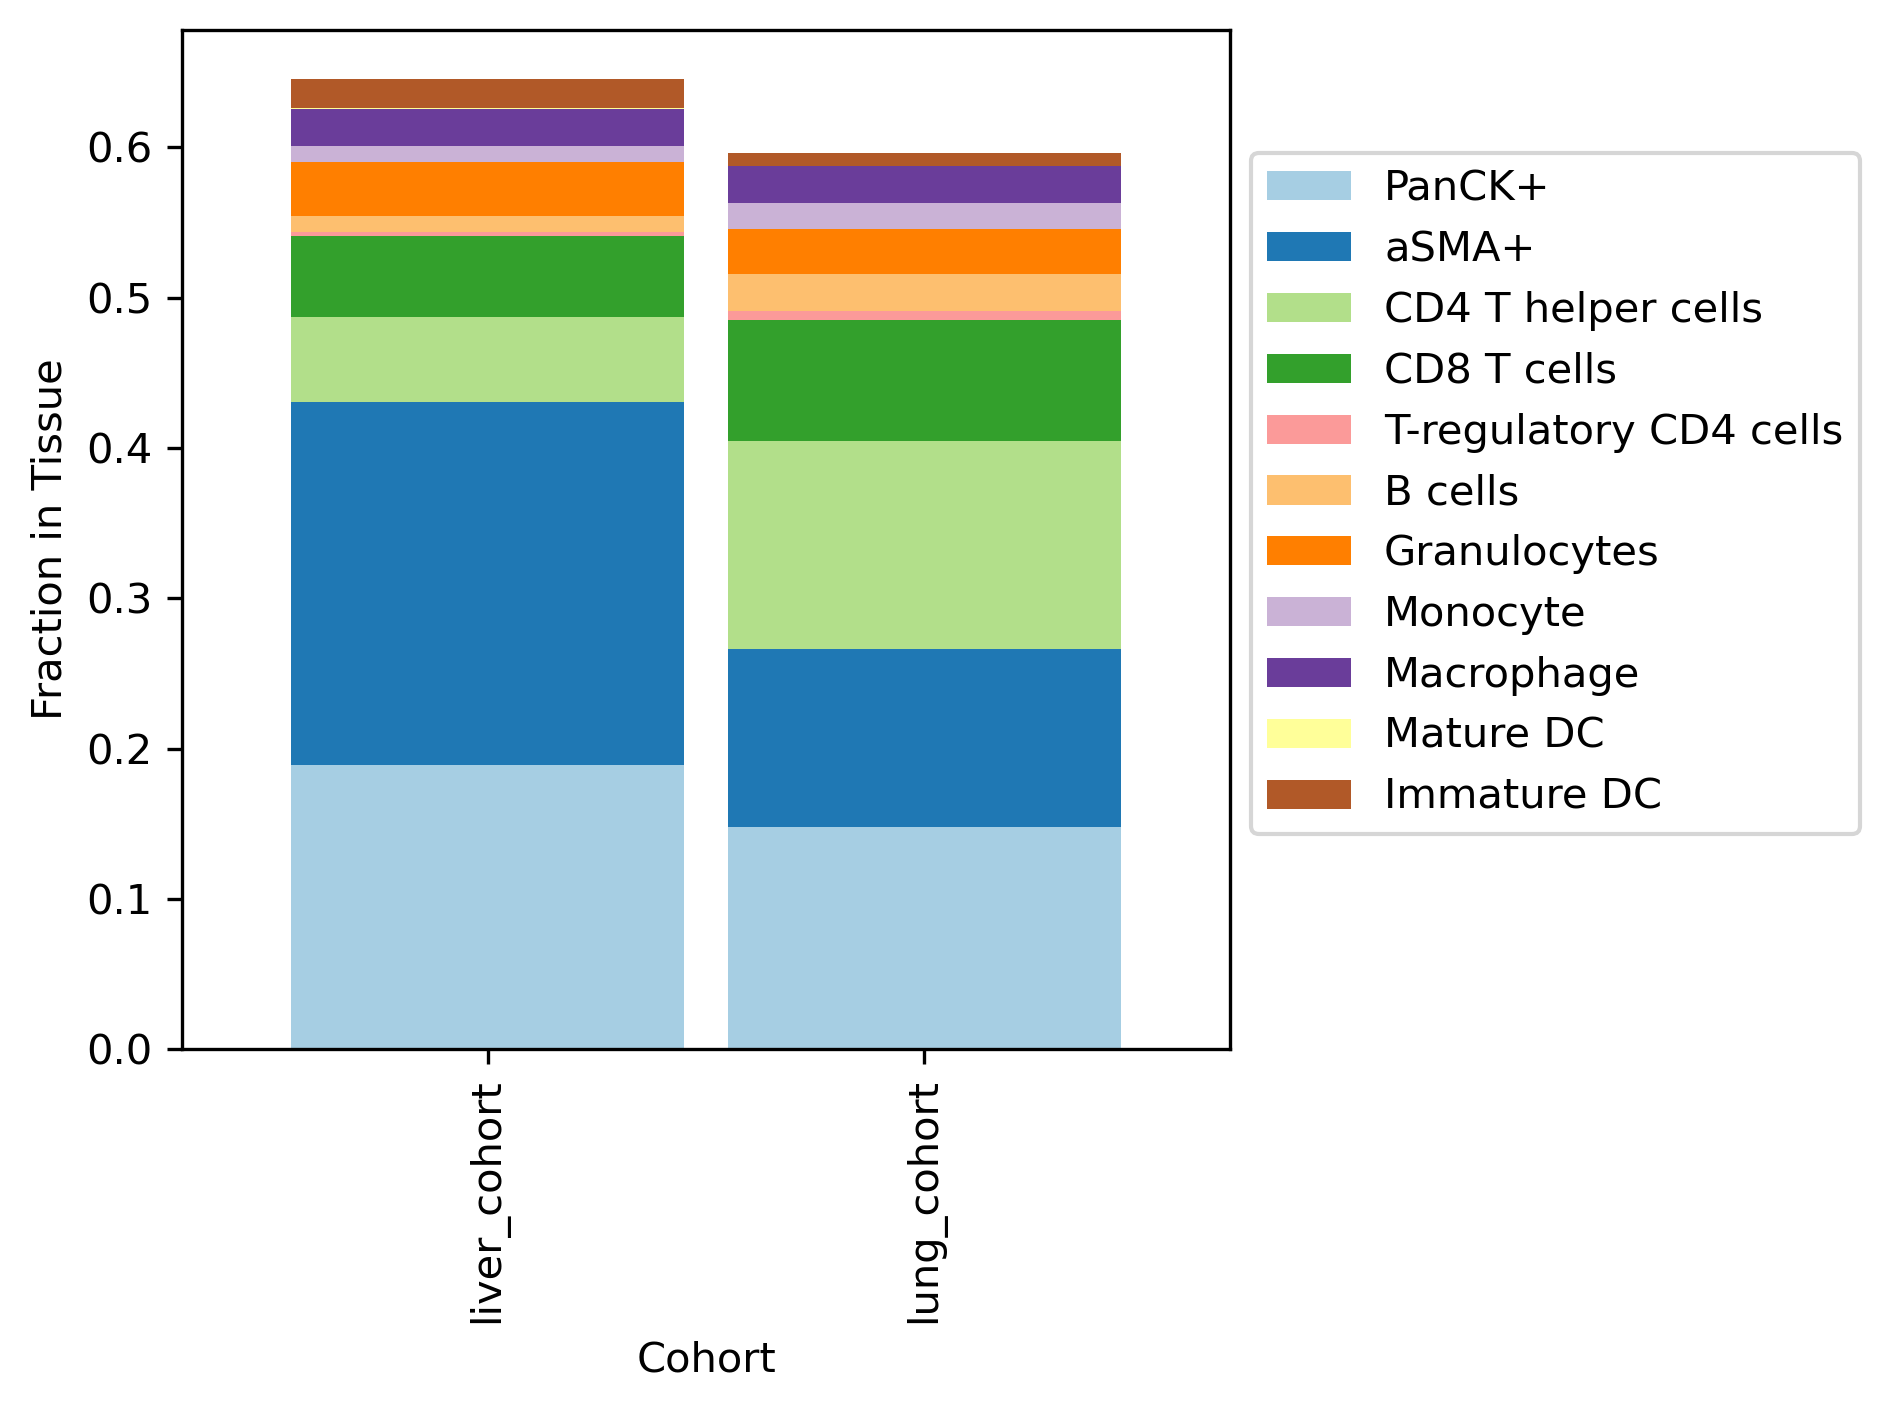

In [30]:
fig,ax=plt.subplots(dpi=300)
df_group.groupby('Cohort').mean().loc[:,ls_mihc].plot(kind='bar',width=.9,stacked=True,ax=ax,colormap='Paired')
ax.legend(bbox_to_anchor=(1,.9))
ax.set_ylabel('Fraction in Tissue')
plt.tight_layout()